<a href="https://colab.research.google.com/github/gowrithampi/deeplearning_with_pytorch/blob/main/Chapter_5_The_mechanics_of_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with Pytorch
## Chapter 5: The Mechanics of Learning

This is a fun chapter it familiarizes one with the idea of learning, by building a simple linear regression model by gradient descent. 

Problem statement : There is a cool thermometer hanging on the wall. It seems to measure temperature, but we don't know what unit it measures temperature in. We want a way to convert the temperature shown by the thermometer to celsius. 


Our strategy: We observe a set of temperature data, from our little pocket celsius thermometer and the corresponding reading from the wall thermometer. Armed with this data, we tackle this problem as a machine learning problem.
Assuming there is a linear relationship between the readings from both thermometers, we use gradient descent to learn the weights of our model. 
First without pytorch's autograd and then with it. 

In [1]:
# t_c is a list of temperatures observed in celsius
# t_u is a list of temperatures observed in unknown units 
import torch
t_c = [0.5, 14.0, 15.0,28.0,11.0,8.0,3.0,-4.0,6.0,13.0,21.0]
t_u = [35.7,55.9,58.2,81.9,56.3,48.9,33.9,21.8,48.4,60.4,68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


Let's visualize above data

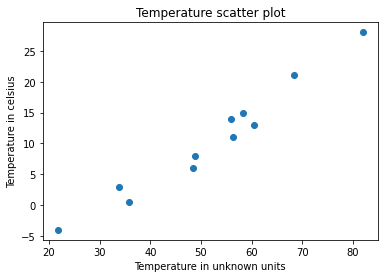

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.scatter(t_u, t_c)
plt.title('Temperature scatter plot')
ax.set_xlabel('Temperature in unknown units')
ax.set_ylabel('Temperature in celsius')
plt.show()

In [1]:
## linear model 
def model (t_u, w , b):
  # predicted temperature is 
  # weight times unknown temp
  # plus bias 
  # w and b are scalars
  # their values get broadcasted
  # across the vector v_u
  t_p = w*t_u +b 
  return t_p